<a href="https://colab.research.google.com/github/Emaan10/Elevvo-ML.internshipTasks/blob/main/Task%203%3A%20Forest%20Cover%20Type%20Classification/Elevvo_Task_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import fetch_covtype
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
import xgboost as xgb
from xgboost import XGBClassifier


Loading Dataset online

In [ ]:
cov = fetch_covtype(as_frame=True)
X = cov.data.copy()
y = cov.target.copy()  # note: labels are 1..7

print("Raw shape:", X.shape)
print("Target distribution:\n", y.value_counts().sort_index())

Raw shape: (581012, 54)
Target distribution:
 Cover_Type
1    211840
2    283301
3     35754
4      2747
5      9493
6     17367
7     20510
Name: count, dtype: int64


Identifying numeric columns

In [ ]:
numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()

Splitting data into Training, Validation and Testing data

In [ ]:
# Split into train/val/test
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y, test_size=0.15, stratify=y, random_state=42
)
X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=0.17647, stratify=y_trainval, random_state=42
)

Spliting dataset shapes

In [ ]:
print("\nSplits:", X_train.shape, X_val.shape, X_test.shape)


Splits: (406708, 54) (87152, 54) (87152, 54)


Adjust labels to be 0-indexed

In [ ]:
# Convert labels to 0-indexed for algorithms that require it (XGBoost older versions)
y_train0 = y_train - 1
y_val0   = y_val - 1
y_test0  = y_test - 1

Random Forest baseline

In [ ]:
# 3) Random Forest baseline
rf_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1))
])

print("\nTraining Random Forest...")
rf_pipeline.fit(X_train, y_train)  # sklearn accepts 1..7 labels

# Eval
y_pred_rf = rf_pipeline.predict(X_test)
rf_acc = accuracy_score(y_test, y_pred_rf)
rf_f1  = f1_score(y_test, y_pred_rf, average='weighted')
print(f"Random Forest - Test Accuracy: {rf_acc:.4f}, Weighted F1: {rf_f1:.4f}")


Training Random Forest...
Random Forest - Test Accuracy: 0.9517, Weighted F1: 0.9514


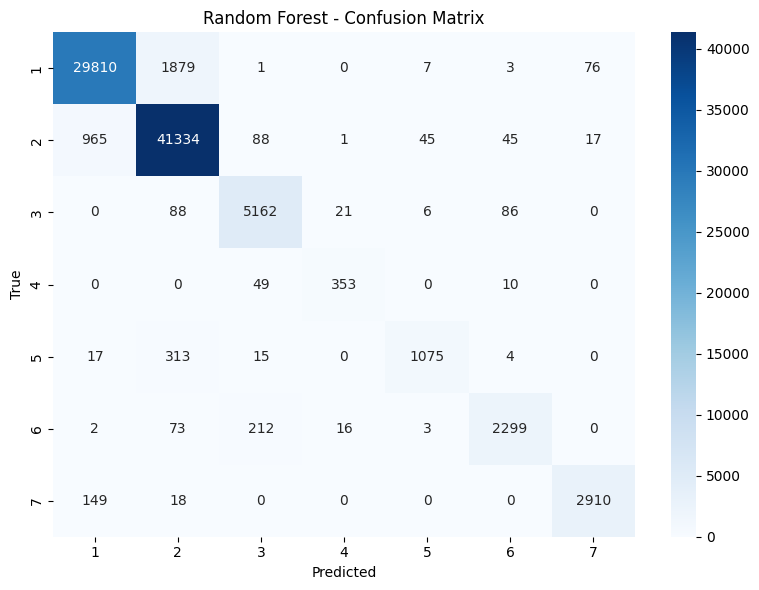

In [ ]:
# Confusion matrix plot function
def plot_conf_matrix(y_true, y_pred, title="Confusion Matrix", labels=None):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(title)
    plt.tight_layout()
    plt.show()

labels = [str(i) for i in sorted(y.unique())]
plot_conf_matrix(y_test, y_pred_rf, title="Random Forest - Confusion Matrix", labels=labels)

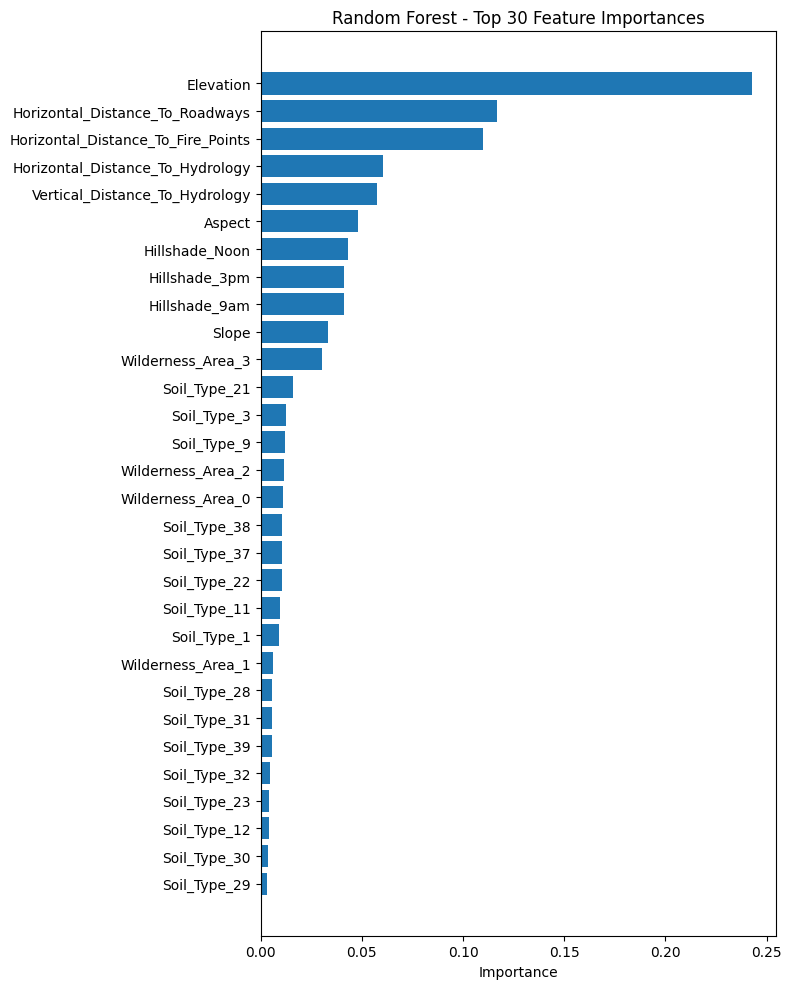

In [ ]:
# Feature importance (sklearn RF)
rf_feat_imp = rf_pipeline.named_steps['clf'].feature_importances_
feat_names = X.columns
imp_df = pd.DataFrame({"feature": feat_names, "importance": rf_feat_imp}).sort_values("importance", ascending=True)
plt.figure(figsize=(8,10))
plt.barh(imp_df['feature'].tail(30), imp_df['importance'].tail(30))
plt.title("Random Forest - Top 30 Feature Importances")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

In [ ]:
print("\nTraining XGBoost...")

# Convert to numpy arrays
X_train_arr = X_train.values
X_val_arr   = X_val.values
X_test_arr  = X_test.values

num_class = len(np.unique(y_train0))

# XGBoost parameters
xgb_params = {
    "objective": "multi:softprob",
    "num_class": num_class,
    "learning_rate": 0.1,
    "max_depth": 8,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "eval_metric": "mlogloss",
    "tree_method": "hist",
    "seed": 42
}

# Train using XGBClassifier without early stopping
xgb_clf = XGBClassifier(
    **{k: v for k, v in xgb_params.items() if k not in ['eval_metric', 'seed']},
    n_estimators=30,     # stop after 15 rounds
    random_state=42,
    n_jobs=-1,
    use_label_encoder=False
)

xgb_clf.fit(
    X_train_arr, y_train0,
    eval_set=[(X_val_arr, y_val0)],
    verbose=True
)

print("Training complete (30 boosting rounds).")


Training XGBoost...
[0]	validation_0-mlogloss:1.74621
[1]	validation_0-mlogloss:1.60422
[2]	validation_0-mlogloss:1.47490
[3]	validation_0-mlogloss:1.36713
[4]	validation_0-mlogloss:1.27674
[5]	validation_0-mlogloss:1.19731
[6]	validation_0-mlogloss:1.13408
[7]	validation_0-mlogloss:1.07665
[8]	validation_0-mlogloss:1.02225
[9]	validation_0-mlogloss:0.97138
[10]	validation_0-mlogloss:0.92737
[11]	validation_0-mlogloss:0.88939
[12]	validation_0-mlogloss:0.85211
[13]	validation_0-mlogloss:0.81962
[14]	validation_0-mlogloss:0.79048
[15]	validation_0-mlogloss:0.76427
[16]	validation_0-mlogloss:0.73691
[17]	validation_0-mlogloss:0.71247
[18]	validation_0-mlogloss:0.69262
[19]	validation_0-mlogloss:0.67263
[20]	validation_0-mlogloss:0.65454
[21]	validation_0-mlogloss:0.63718
[22]	validation_0-mlogloss:0.62116
[23]	validation_0-mlogloss:0.60677
[24]	validation_0-mlogloss:0.59285
[25]	validation_0-mlogloss:0.58007
[26]	validation_0-mlogloss:0.56860
[27]	validation_0-mlogloss:0.55728
[28]	vali


Evaluating XGBoost...
XGBoost - Test Accuracy: 0.8237, Weighted F1: 0.8206


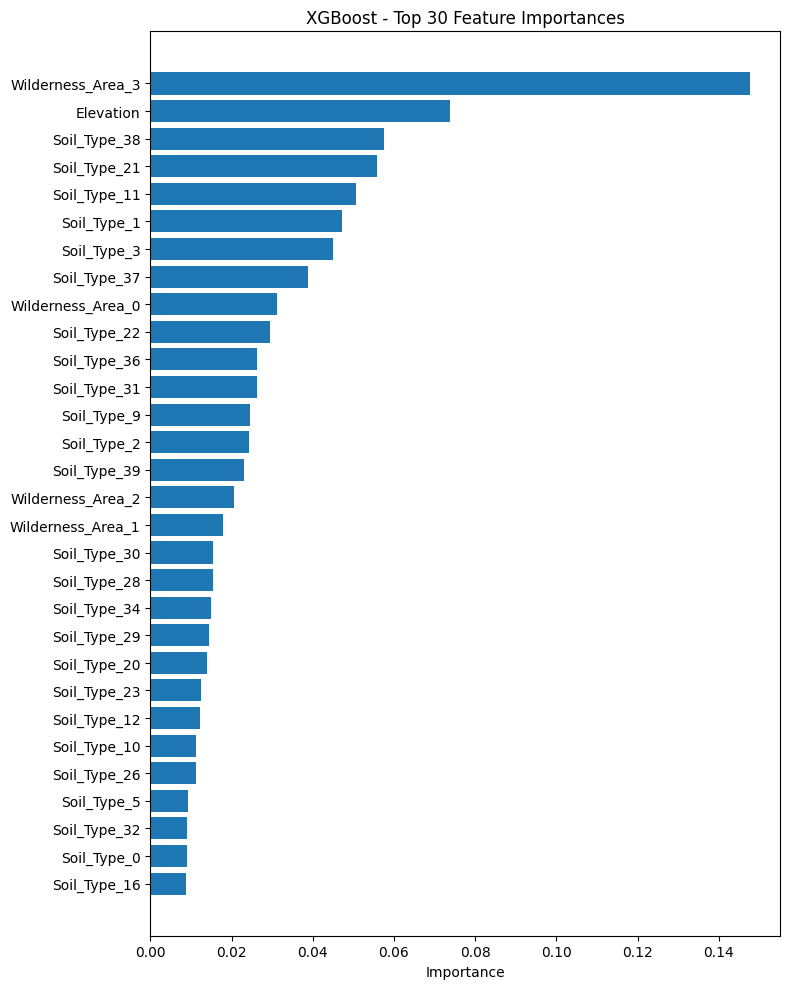

In [ ]:
print("\nEvaluating XGBoost...")

# Predictions (probabilities → class labels)
y_pred_xgb   = xgb_clf.predict(X_test_arr)

# Convert back to original label space (1..num_class)
y_pred_xgb_labels = y_pred_xgb + 1

# Evaluation
xgb_acc = accuracy_score(y_test, y_pred_xgb_labels)
xgb_f1  = f1_score(y_test, y_pred_xgb_labels, average='weighted')
print(f"XGBoost - Test Accuracy: {xgb_acc:.4f}, Weighted F1: {xgb_f1:.4f}")

# Feature importance
imp_df = pd.DataFrame({
    "feature": feat_names,
    "importance": xgb_clf.feature_importances_
}).sort_values("importance", ascending=True)

plt.figure(figsize=(8,10))
plt.barh(imp_df['feature'].tail(30), imp_df['importance'].tail(30))
plt.title("XGBoost - Top 30 Feature Importances")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

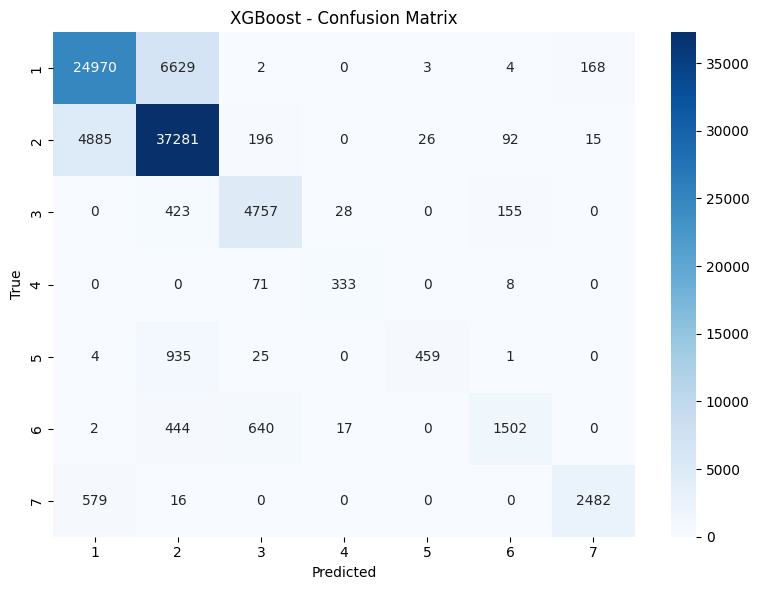

In [ ]:
# XGBoost Confusion Matrix
labels = [str(i) for i in sorted(y.unique())]
plot_conf_matrix(y_test, y_pred_xgb_labels,
                 title="XGBoost - Confusion Matrix",
                 labels=labels)


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

print("\n Hyperparameter Tuning - Random Forest")
rf = RandomForestClassifier(random_state=42, n_jobs=-1)
rf_param_grid = {
    "n_estimators": [100, 200],
    "max_depth": [10, 20]
}
rf_grid = GridSearchCV(rf, rf_param_grid, cv=3, scoring='f1_weighted', n_jobs=-1, verbose=1)
rf_grid.fit(X_train, y_train)

print("Best RF params:", rf_grid.best_params_)
best_rf = rf_grid.best_estimator_
y_pred_rf = best_rf.predict(X_test)
print("Tuned RF - Accuracy:", accuracy_score(y_test, y_pred_rf),
      "F1:", f1_score(y_test, y_pred_rf, average='weighted'))


print("\n Hyperparameter Tuning - XGBoost")
xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', n_jobs=-1, random_state=42)
xgb_param_grid = {
    "n_estimators": [100, 200],
    "max_depth": [6, 8],
    "learning_rate": [0.1, 0.05]
}
xgb_grid = GridSearchCV(xgb, xgb_param_grid, cv=3, scoring='f1_weighted', n_jobs=-1, verbose=1)
xgb_grid.fit(X_train.values, y_train0)   # using 0-indexed labels

print("Best XGB params:", xgb_grid.best_params_)
best_xgb = xgb_grid.best_estimator_
y_pred_xgb = best_xgb.predict(X_test.values)
y_pred_xgb_labels = y_pred_xgb + 1   # convert back to 1..K labels

print("Tuned XGB - Accuracy:", accuracy_score(y_test, y_pred_xgb_labels),
      "F1:", f1_score(y_test, y_pred_xgb_labels, average='weighted'))



 Hyperparameter Tuning - Random Forest
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Best RF params: {'max_depth': 20, 'n_estimators': 200}
Tuned RF - Accuracy: 0.890042684046264 F1: 0.8879821292647232

 Hyperparameter Tuning - XGBoost
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best XGB params: {'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 200}
Tuned XGB - Accuracy: 0.8904328070497521 F1: 0.8897902340840264


In [ ]:
print(f"Random Forest (baseline) Accuracy: {rf_acc:.4f}, F1: {rf_f1:.4f}")
print(f"XGBoost (baseline) Accuracy: {xgb_acc:.4f}, F1: {xgb_f1:.4f}")


Random Forest (baseline) Accuracy: 0.9517, F1: 0.9514
XGBoost (baseline) Accuracy: 0.8237, F1: 0.8206


In [ ]:
results = pd.DataFrame([
    {"Model": "Random Forest (Baseline)", "Accuracy": rf_acc, "F1": rf_f1},
    {"Model": "XGBoost (Baseline)", "Accuracy": xgb_acc, "F1": xgb_f1},
    {"Model": "Random Forest (Tuned)", "Accuracy": accuracy_score(y_test, y_pred_rf), "F1": f1_score(y_test, y_pred_rf, average='weighted')},
    {"Model": "XGBoost (Tuned)", "Accuracy": accuracy_score(y_test, y_pred_xgb_labels), "F1": f1_score(y_test, y_pred_xgb_labels, average='weighted')}
])
print("\nFinal Comparison:")
print(results)


Final Comparison:
                      Model  Accuracy        F1
0  Random Forest (Baseline)  0.951705  0.951423
1        XGBoost (Baseline)  0.823664  0.820634
2     Random Forest (Tuned)  0.890043  0.887982
3           XGBoost (Tuned)  0.890433  0.889790
